In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Memuat data
#data_path = 'meninggalminus.csv'
#data = pd.read_csv(data_path)
#data['Clean']=data['Clean'].apply(cleaning)

data = pd.read_csv('drive/MyDrive/TESIS/dataclustering/sembuh_plus.csv')

data.head()

,Unnamed: 0,Clean,Tanggal
0,0,"0.015*""banjir"" + 0.015*""bantu"" + 0.008*""pesawa...",1-28
1,1,"0.021*""awan_panas"" + 0.016*""barak_ungsi"" + 0.0...",1-28
2,2,"0.012*""listyo_sigit"" + 0.009*""kota_yogyakarta""...",1-28
3,3,"0.013*""vaksin"" + 0.009*""jalan_isolasi"" + 0.008...",1-28
4,4,"0.027*""abu_janda"" + 0.015*""partai_demokrat"" + ...",2-11


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Ekstraksi kata kunci dari kolom 'Clean'
# Menggunakan regex untuk mengekstrak kata-kata kunci (mengabaikan bobot)
data['keywords'] = data['Clean'].apply(lambda x: ' '.join(re.findall(r'"([^"]*)"', x)))

# Inisialisasi TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Transformasi kata-kata kunci menjadi matriks TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(data['keywords'])

# Melihat bentuk matriks TF-IDF
tfidf_matrix.shape

(78, 517)

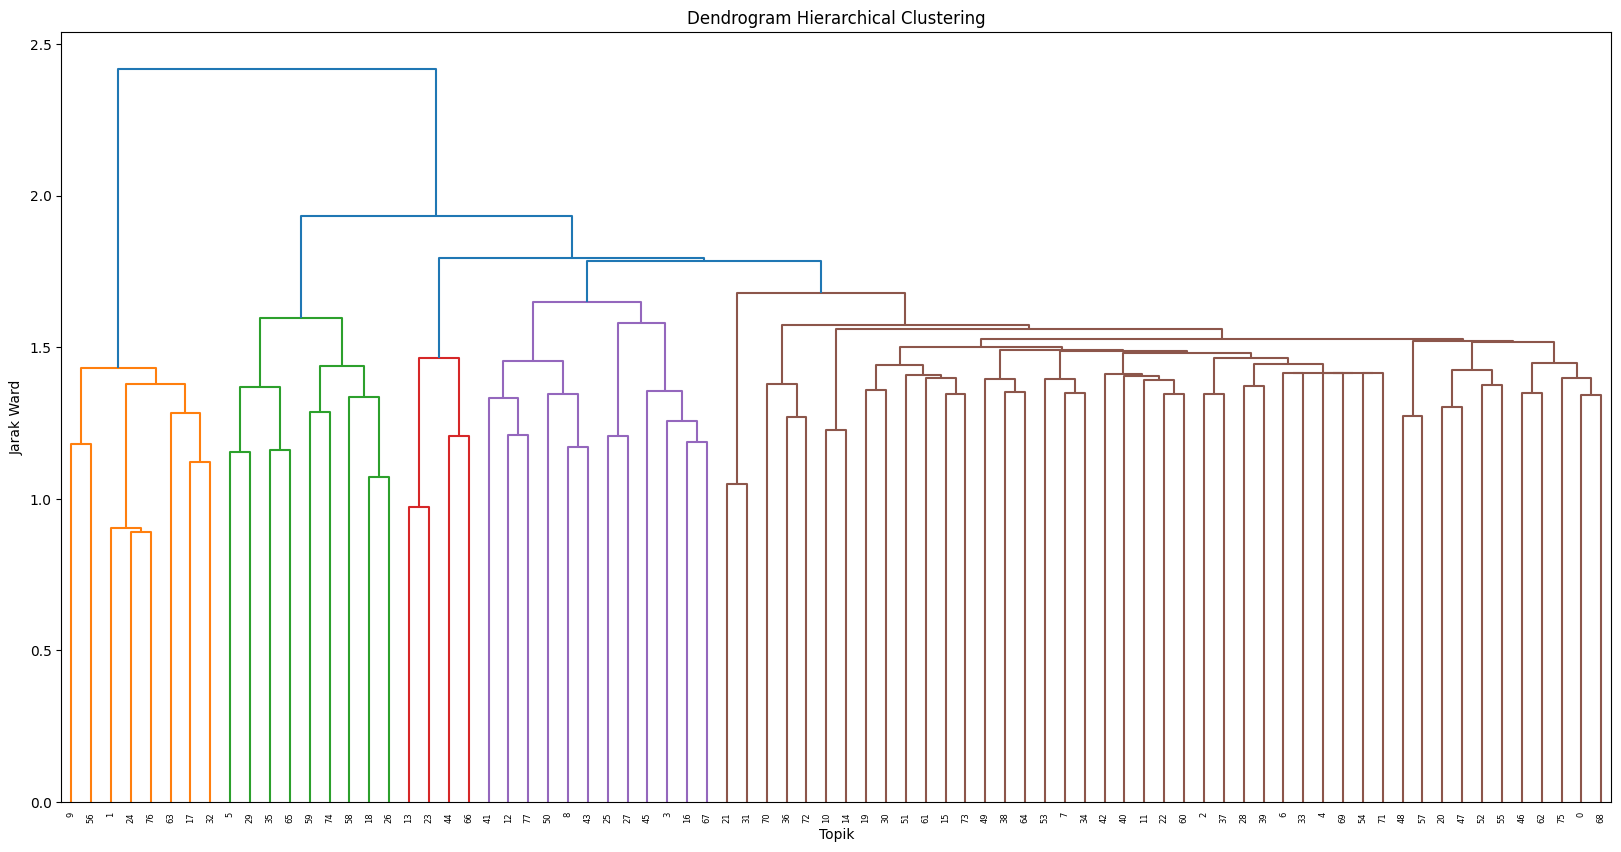

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Menghitung matriks linkage menggunakan metode 'ward'
linkage_matrix = linkage(tfidf_matrix.toarray(), method='ward')

# Visualisasi hasil clustering dengan dendrogram
plt.figure(figsize=(20, 10))
dendrogram(linkage_matrix, no_labels=False)
plt.title('Dendrogram Hierarchical Clustering')
plt.xlabel('Topik')
plt.ylabel('Jarak Ward')
plt.show()

In [ ]:
from scipy.cluster.hierarchy import fcluster

# Menentukan cluster berdasarkan threshold jarak Ward
threshold_distance = 1.6
clusters = fcluster(linkage_matrix, threshold_distance, criterion='distance')

# Menambahkan label cluster ke data asli
data['cluster'] = clusters

# Menghitung jumlah data per cluster
cluster_distribution = data['cluster'].value_counts()

cluster_distribution

9     34
10    19
5     14
6     13
8     11
12    10
4      9
2      8
1      7
11     6
14     5
13     4
3      4
7      2
Name: cluster, dtype: int64

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Assumsi bahwa tfidf_matrix dan data sudah didefinisikan, dan clustering telah dilakukan seperti pada kode yang diberikan

# Skor Silhouette
silhouette_avg = silhouette_score(tfidf_matrix, data['cluster'])
print(f"Silhouette Coefficient(Higher): {silhouette_avg}")

# Skor Calinski-Harabasz
calinski_harabasz_avg = calinski_harabasz_score(tfidf_matrix.toarray(), data['cluster'])
print(f"Calinski-Harabasz Index (Higher): {calinski_harabasz_avg}")

# Skor Davies-Bouldin
davies_bouldin_avg = davies_bouldin_score(tfidf_matrix.toarray(), data['cluster'])
print(f"Davies-Bouldin Index (Lower): {davies_bouldin_avg}")

Silhouette Coefficient(Higher): 0.016931272426836803
Calinski-Harabasz Index (Higher): 1.779303007021073
Davies-Bouldin Index (Lower): 3.891480697530276


In [ ]:
# Menampilkan kata kunci yang paling sering muncul dalam setiap cluster
# Menampilkan kata kunci yang paling sering muncul dalam setiap cluster
for cluster_num in sorted(data['cluster'].unique()):
    print(f"Kata-kata kunci paling sering muncul di Cluster {cluster_num}:")
    cluster_keywords = data[data['cluster'] == cluster_num]['keywords'].str.cat(sep=' ')
    keywords_freq = pd.Series(cluster_keywords.split()).value_counts().head(10)

    # Format hasil untuk mencetak dalam gaya yang diinginkan
    formatted_keywords_freq = ', '.join([f"{word} ({freq})" for word, freq in keywords_freq.items()])
    print(formatted_keywords_freq + " ,",("\n"))

Kata-kata kunci paling sering muncul di Cluster 1:
gunung_rapi (6), jarak_luncur (6), awan_panas (5), awan (4), rapi (4), gugur (3), barat_daya (3), arah_barat (3), gunung (2), panas (2) , 

Kata-kata kunci paling sering muncul di Cluster 2:
kabupaten_sleman (3), kabupaten_bantul (3), tracing_kontak (3), tambah (3), periksa_mandiri (2), kota_yogyakarta (2), konfirmasi_positif (2), juru_bicara (2), positif (2), kabupaten_gunungkidul (1) , 

Kata-kata kunci paling sering muncul di Cluster 3:
korban (8), tinggal_dunia (4), temu (4), sepeda_motor (3), rumah_sakit (3), polisi (3), tni (3), kulonprogo (3), muhammadiyah (2), saksi (2) , 

Kata-kata kunci paling sering muncul di Cluster 4:
kabupaten_sleman (4), kabag_humas (3), pemda_diy (2), pasar (2), bupati_sleman (2), ngaglik (2), positif_covid (2), pemkab_sleman (2), kota_yogyakarta (2), obat (2) , 

Kata-kata kunci paling sering muncul di Cluster 5:
bantul (4), kota_yogyakarta (4), gunungkidul (4), salah_satu (4), salat (3), korban (3), 

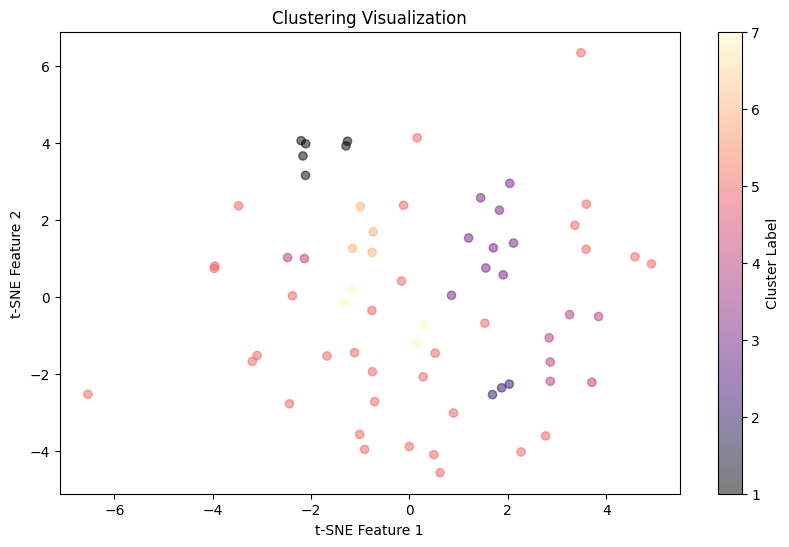

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduksi dimensi dengan t-SNE
tfidf_array = tfidf_matrix.toarray()  # Konversi tfidf_matrix ke dense array jika belum
tsne = TSNE(n_components=2, random_state=42)
tfidf_tsne = tsne.fit_transform(tfidf_array)

# Visualisasi dengan scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1], c=data['cluster'], cmap='magma', alpha=0.5)
plt.colorbar(label='Cluster Label')
plt.title('Clustering Visualization')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()

In [ ]:
data

,Unnamed: 0,Clean,Tanggal,keywords,cluster
0,0,"0.015*""banjir"" + 0.015*""bantu"" + 0.008*""pesawa...",1-28,banjir bantu pesawat selatan serah m lepas ben...,3
1,1,"0.021*""awan_panas"" + 0.016*""barak_ungsi"" + 0.0...",1-28,awan_panas barak_ungsi gunung_rapi ungsi jarak...,1
2,2,"0.012*""listyo_sigit"" + 0.009*""kota_yogyakarta""...",1-28,listyo_sigit kota_yogyakarta ugm rumah_sakit d...,4
3,3,"0.013*""vaksin"" + 0.009*""jalan_isolasi"" + 0.008...",1-28,vaksin jalan_isolasi vaksinasi harga tenaga_se...,4
4,4,"0.017*""kulonprogo"" + 0.015*""humas_polres"" + 0....",3-25,kulonprogo humas_polres temu sekolah korban mu...,3
...,...,...,...,...,...
62,62,"0.026*""mobil"" + 0.025*""kurban"" + 0.021*""hewan_...",7-29,mobil kurban hewan_kurban sapi hewan potong_he...,4
63,63,"0.035*""daerah_istimewa"" + 0.027*""bina"" + 0.019...",7-29,daerah_istimewa bina gejala_ringan purworejo i...,4
64,64,"0.011*""ayam"" + 0.010*""lurah"" + 0.007*""kabupate...",11-4,ayam lurah kabupaten_sleman ngaglik_sleman dag...,4
65,65,"0.011*""celaka"" + 0.010*""rumah_sakit"" + 0.009*""...",11-4,celaka rumah_sakit alami_luka vanessa tinggal_...,3


In [ ]:

data.to_csv('clusterkasusplus7.csv')